# MTC evaluation


### Summary

- Overall performance comparison 

### Main takeaways

Despite often scoring the lowest out of all the models, MTC still displays satistfying accuracy, its average MCC across the different datasets not being too distant from that of the best performing models:
- .3 ca from the absolute best in 1/4 cases;
- .1 ca in 2/4 cases;
- .01 on the Breast Cancer dataset. 

On the other hand, MTC outperforms almost all the models when it comes to computational efficiency:
- training time
    - is significantly lower than RF, AdaBoost and SVM;
    - is aligned with k-NN (which has a higher prediction time)
- prediction time
    - is aligned with RF, AdaBoost and SVM;
    - is lower than k-NN.
    
To conclude, MTC's performance displays an interesting blend between accuracy and efficiency.   
Further insight is expected as a result of sensitivity analysis.


# 2.1. Overall performance comparison

We ran a **comparative evaluation**, using MTClassifier alongside other common **machine learning algorithms**.

Given MTC's characteristics, the following algorithms were selected for the analysis:
- Random Forest
- AdaBoost
- Support Vector Machine 
- k-Nearest Neighbors


### Data (RIVEDERE)

The evaluation procedure is carried out on **5 different datasets**:

- 2 synthetic datasets;
- the Breast Cancer dataset;
- the Orange vs. Grapefruit dataset;
- the Credit Card Fraud dataset.

### Procedure
For each dataset, data creation/retrieval, splitting and scaling are carried out as a preprocessing step.

Then, models are initialized: 
   - MTC with best parameters, resulted from tuning (see *eval_MTC_1*);
   - **!**: The other models have also been previously tuned - some parameters are set according to literature indications;
   
A **K-fold cross validation** mechanism is **nested in the evaluation** procedure for more robust results:

1. K folds are created; 

2. For each fold:
    - training data is split in training and validation sets;
    - each classifier is trained and evaluated on the validation set;
    - metrics and time are calculated ;
3. Average metrics - on the k folds - are computed:
    - Matthew's Correlation Coefficient - main metric for our analysis
    - Cohen's Kappa Score - to monitor coherence, in case any anomalies arise in MCCs
    - Training time
    - Prediction time
3. (Each class is also evaluated (same metrics) on the test set);  
    - not currently implemented as of now
    - we still create the test set, in case we need to compare predictions from cross-validation

4. Results are visualized
    - three functions defined to plot MCCs and time metrics



In [109]:
#importing necessary items

#our classifier
from MTC2 import MTClust, MTClustT, MTClassifier

#import libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, sample, seed
import time

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, confusion_matrix

#import algorithms
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [34]:
#creating visualization functions
    
#defining font
helv = {'family': 'helvetica',
        'weight': 'normal'
}

#defining plotting functions
def plotBoxplots(metrics, classifiers):
    
    colors = ['darkorchid', 'darkblue', 'mediumturquoise', 'mediumseagreen', 'yellowgreen']
    fig, ax = plt.subplots(figsize=(8, 7))
    
    mccs = [metrics["Matthews Correlation Coefficient"][clf_name] for clf_name in classifiers.keys()]
    bp = ax.boxplot(mccs, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    #ax.set_title(f'Distribution of {metric_name} Scores Across Algorithms', fontsize=15)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_xticks(list(range(1, len(classifiers) + 1)))
    ax.set_xticklabels(classifiers.keys(), font=helv, fontsize=13)
    ax.tick_params(axis='x', rotation=45)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)

    plt.tight_layout()
    plt.show()
        
def plotBars(metrics, classifiers, bar_thickness=0.5):
    
    colors = ['darkorchid', 'darkblue', 'mediumturquoise', 'mediumseagreen', 'yellowgreen']
    fig, ax = plt.subplots(figsize=(8, 5))
    
    #retrieve average MCCs
    mcc_avg = [average_metrics[clf_name]["Matthews Correlation Coefficient"][0] for clf_name in classifiers.keys()]

    bars = ax.barh(range(len(classifiers)), mcc_avg, color=colors, height=bar_thickness)
    ax.set_yticks(list(range(len(classifiers))))
    ax.set_yticklabels(classifiers.keys(), font=helv, fontsize=13)
    ax.invert_yaxis()

    for i, bar in enumerate(bars):
        ax.text(bar.get_width() - 0.02, bar.get_y() + bar.get_height()/2, 
                f'{mcc_avg[i]:.2f}', 
                va='center', ha='right', color='white', fontsize=13)

    #ax.set_title('Average Matthews Correlation Coefficient Scores Across Algorithms', fontsize=14)
    ax.set_xlabel('MCC', font=helv, fontsize=13)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    plt.tight_layout()
    plt.show()
       
def plotTimes(average_metrics, classifiers):
    
    #retrieve means and standard deviations for time metrics
    tt_mean = [average_metrics[clf_name]["Training Time"][0] for clf_name in classifiers.keys()]
    tt_std = [average_metrics[clf_name]["Training Time"][1] for clf_name in classifiers.keys()]
    pt_mean = [average_metrics[clf_name]["Prediction Time"][0] for clf_name in classifiers.keys()]
    pt_std = [average_metrics[clf_name]["Prediction Time"][1] for clf_name in classifiers.keys()]

    bar_width = 0.35
    index = np.arange(len(classifiers))
    
    fig, ax = plt.subplots(figsize=(7, 6))

    bars1 = ax.bar(index, tt_mean, bar_width, yerr=tt_std,
                   label='Training Time', alpha=0.7, color='teal')
    bars2 = ax.bar(index + bar_width, pt_mean, bar_width, yerr=pt_std,
                   label='Prediction Time', alpha=0.7, color='orange')
    
    ax.set_xlabel('Classifier', font=helv, fontsize=13)
    ax.set_ylabel('Time (s)', font=helv, fontsize=13)
    #ax.set_title('Training and Prediction Times for Classifiers', fontsize=14)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(classifiers.keys(), font=helv)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [132]:
#initializing models

rf = RandomForestClassifier(n_estimators=200, random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),learning_rate=0.1, n_estimators=200, random_state=42)
svm = SVC(C=10, probability=True, random_state=42)
knn = KNeighborsClassifier(metric='euclidean')
seed(7)
mtc = MTClassifier(n_parts=10, max_depth=20, min_instances=5, use_binary_class=True, dist_func="euclidean")

#storing initialized models in a dictionary
classifiers = {
    "Random Forest": rf,
    "AdaBoost": ada,
    "Support Vector Machine": svm,
    "k-Nearest Neighbors": knn,
    "MTClassifier": mtc
}

## Dataset 1 

Synthetic.

5k instances but high number of features, 0.4 informative feature ratio, balanced but three clusters per class

In [133]:
#STEP 1: preprocessing

#creating dataset
X, y = make_classification(
    n_samples=5000,
    n_features=100,
    n_informative=15,
    n_redundant=35,
    
    n_classes=2,
    n_clusters_per_class=3,
    weights=[0.5,0.5],
    flip_y=0.03,
    class_sep=0.7,
    
    random_state=42)

#splitting, scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#counting number of instances per class
label_counts = pd.Series(y).value_counts()
print(label_counts)

0    2500
1    2500
dtype: int64


In [134]:
#STEP 2: evaluating 

#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.691, Cohen's Kappa Score: 0.690
    Training Time: 3.961s, Prediction Time: 0.068s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.584, Cohen's Kappa Score: 0.583
    Training Time: 19.849s, Prediction Time: 0.076s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.683, Cohen's Kappa Score: 0.683
    Training Time: 6.123s, Prediction Time: 0.744s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.605, Cohen's Kappa Score: 0.603
    Training Time: 0.001s, Prediction Time: 0.185s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.533, Cohen's Kappa Score: 0.531
    Training Time: 0.826s, Prediction Time: 0.225s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - Matth

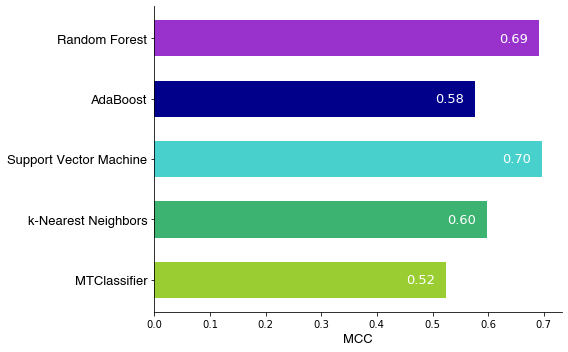

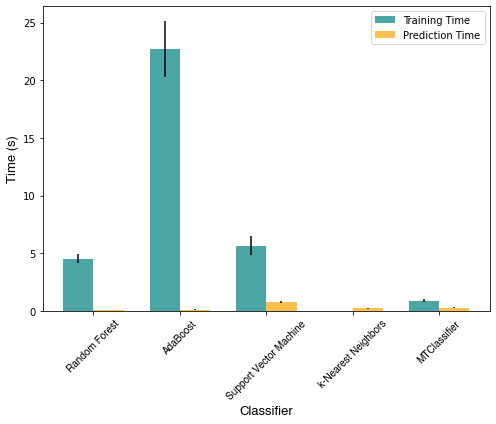

In [135]:
#STEP 3: visualizing

#plotBoxplots(metrics, classifiers)
plotBars(metrics, classifiers, bar_thickness=0.6)
plotTimes(average_metrics, classifiers)

## Dataset 2

Synthetic.

50k instances but few features, 0.2 informative feature ratio, imbalanced (4:1 ratio) but one cluster per class

In [136]:
#STEP 1: preprocessing

#creating dataset
X, y = make_classification(
    n_samples=50000,
    n_features=25,
    n_informative=2,
    n_redundant=3,
    
    n_classes=2,
    n_clusters_per_class=1,
    weights=[0.8,0.2],
    flip_y=0.02,
    class_sep=0.6,
    
    random_state=42)

#splitting and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#counting number of instances per class
label_counts = pd.Series(y).value_counts()
print(label_counts)

0    39701
1    10299
dtype: int64


In [137]:
#STEP 2: evaluating

#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.897, Cohen's Kappa Score: 0.893
    Training Time: 48.388s, Prediction Time: 0.789s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.879, Cohen's Kappa Score: 0.873
    Training Time: 84.862s, Prediction Time: 0.634s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.785, Cohen's Kappa Score: 0.774
    Training Time: 513.379s, Prediction Time: 11.957s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.415, Cohen's Kappa Score: 0.372
    Training Time: 0.003s, Prediction Time: 9.872s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.366, Cohen's Kappa Score: 0.279
    Training Time: 4.713s, Prediction Time: 1.113s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - M

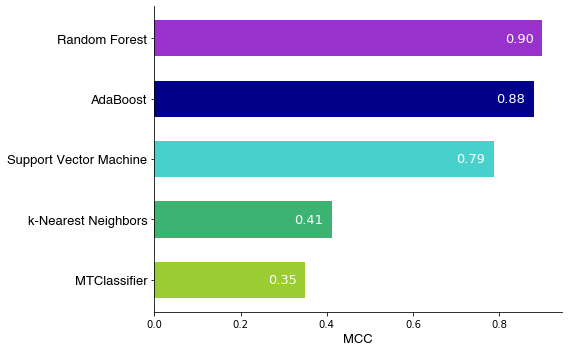

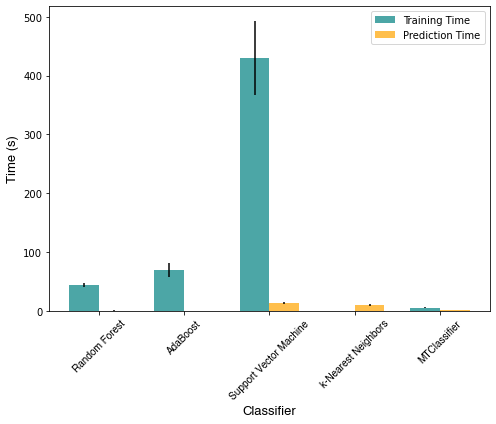

In [138]:
#STEP 3: visualizing

#plotBoxplots(metrics, classifiers)
plotBars(metrics, classifiers, bar_thickness=0.6)
plotTimes(average_metrics, classifiers)

Results for MTC - and kNN - were significantly lower (MCCs around 0.4) when the ratio of informative feature was 0.2

MTC doesn't cope well with noise??

## Dataset 3 - Breast Cancer, Wisconsin

In [148]:
#fetch dataset
from sklearn.datasets import load_breast_cancer

#load dataset
data = load_breast_cancer()
X = data.data
y = data.target

X.shape, y.shape

((569, 30), (569,))

In [89]:
#STEP 1: preprocessing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#counting number of instances per class
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    357
0    212
dtype: int64

In [90]:
#STEP 2: evaluating

#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.911, Cohen's Kappa Score: 0.910
    Training Time: 0.301s, Prediction Time: 0.016s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.883, Cohen's Kappa Score: 0.883
    Training Time: 0.606s, Prediction Time: 0.027s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.955, Cohen's Kappa Score: 0.955
    Training Time: 0.008s, Prediction Time: 0.001s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.941, Cohen's Kappa Score: 0.941
    Training Time: 0.002s, Prediction Time: 0.008s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.956, Cohen's Kappa Score: 0.955
    Training Time: 0.026s, Prediction Time: 0.007s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - Matthe

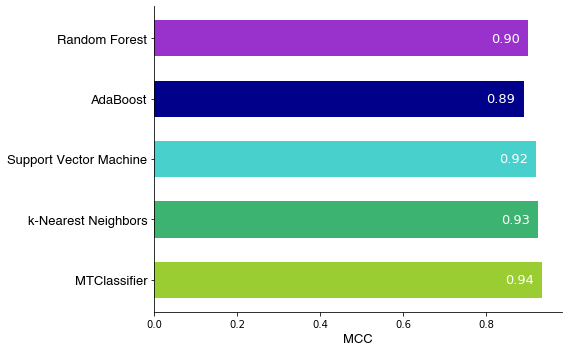

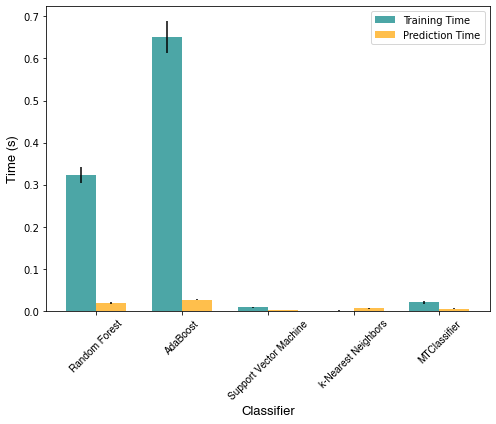

In [91]:
#STEP 3: visualizing

#plotBoxplots(metrics, classifiers)
plotBars(metrics, classifiers, bar_thickness=0.6)
plotTimes(average_metrics, classifiers)

## Dataset 4 - Orange vs Grapefruit

In [93]:
df = pd.read_csv('citrus.csv')
df

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9
...,...,...,...,...,...,...
9995,grapefruit,15.35,253.89,149,77,20
9996,grapefruit,15.41,254.67,148,68,7
9997,grapefruit,15.59,256.50,168,82,20
9998,grapefruit,15.92,260.14,142,72,11


In [96]:
#STEP 1: preprocessing

#store targets in y, data in X
y = df['name'].values 
X = df.drop(columns=['name'])

#train/test split, scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#counting n of oranges and grapefruits
label_counts = pd.Series(y).value_counts()
print(label_counts)

orange        5000
grapefruit    5000
dtype: int64


In [71]:
#STEP 2: evaluating

#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.900, Cohen's Kappa Score: 0.899
    Training Time: 1.015s, Prediction Time: 0.074s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.971, Cohen's Kappa Score: 0.971
    Training Time: 1.829s, Prediction Time: 0.052s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.927, Cohen's Kappa Score: 0.926
    Training Time: 1.536s, Prediction Time: 0.176s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.844, Cohen's Kappa Score: 0.844
    Training Time: 0.006s, Prediction Time: 0.059s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.847, Cohen's Kappa Score: 0.847
    Training Time: 0.268s, Prediction Time: 0.061s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - Matthe

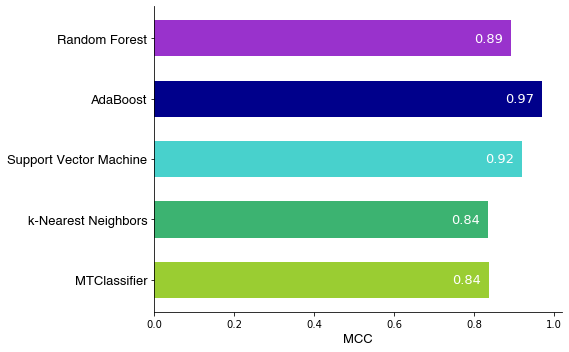

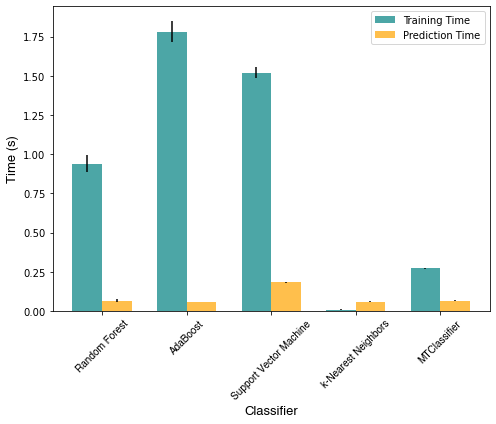

In [67]:
#STEP 3: visualizing

#plotBoxplots(metrics, classifiers)
plotBars(metrics, classifiers, bar_thickness=0.6)
plotTimes(average_metrics, classifiers)

## Dataset 5 - Credit Card Fraud

From Kaggle

In [149]:
df = pd.read_csv('creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [150]:
#STEP 1: preprocessing

#store targets in y, data in X
y = df['class'].values 
X = df.drop(columns=['class'])

#train/test split, scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#counting number of instances per class
label_counts = pd.Series(y).value_counts()
print(label_counts)

0    284315
1       492
dtype: int64


In [151]:
#STEP 2: evaluating

#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.840, Cohen's Kappa Score: 0.836
    Training Time: 208.100s, Prediction Time: 1.090s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.857, Cohen's Kappa Score: 0.852
    Training Time: 404.378s, Prediction Time: 2.577s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.772, Cohen's Kappa Score: 0.759
    Training Time: 389.081s, Prediction Time: 14.945s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.784, Cohen's Kappa Score: 0.779
    Training Time: 0.008s, Prediction Time: 228.293s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.855, Cohen's Kappa Score: 0.852
    Training Time: 8.090s, Prediction Time: 1.128s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest

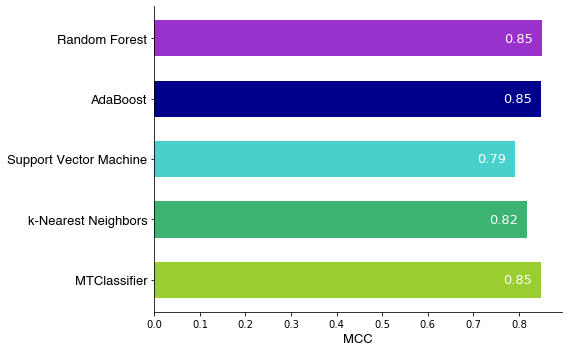

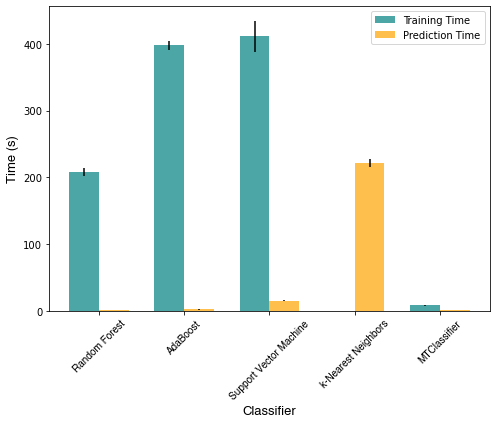

In [152]:
#STEP 3: visualizing

#plotBoxplots(metrics, classifiers)
plotBars(metrics, classifiers, bar_thickness=0.6)
plotTimes(average_metrics, classifiers)

## Dataset 6 - Forest Covertype

In [163]:
#MODELS ON AND OFF (leave MTC only, put binary_class on False)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),learning_rate=0.1, n_estimators=200, random_state=42)
svm = SVC(C=10, probability=True, random_state=42)
knn = KNeighborsClassifier(metric='euclidean')
seed(7)
mtc = MTClassifier(n_parts=10, max_depth=20, min_instances=5, use_binary_class=True, dist_func="euclidean")

#storing initialized models in a dictionary
classifiers = {
    #"Random Forest": rf,
    #"AdaBoost": ada,
    #"Support Vector Machine": svm,
    #"k-Nearest Neighbors": knn,
    "MTClassifier": mtc
}

In [154]:
#fetch dataset

from sklearn.datasets import fetch_openml

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
column_names = [f"feat_{i}" for i in range(1, 55)] + ["Cover_Type"]
df = pd.read_csv(url, header=None, names=column_names)
df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


### Proviamo tutti gli alg

In [157]:
#STEP 1: preprocessing

#store targets in y, data in X
y = df['Cover_Type'].values 
X = df.drop(columns=['Cover_Type'])

#train/test split, scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#counting number of instances per class
label_counts = pd.Series(y).value_counts()
print(label_counts)

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
dtype: int64


In [128]:
#STEP 2: evaluating

#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.913, Cohen's Kappa Score: 0.913
    Training Time: 133.527s, Prediction Time: 10.124s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.915, Cohen's Kappa Score: 0.914
    Training Time: 173.049s, Prediction Time: 13.624s

Evaluating fold 3...
    Evaluating Random Forest...



KeyboardInterrupt



## Binarized Forest Covertype

We are running MTC with the clustering class (MTClust) on the Forest Covertype.  
We are computing confusion matrices so that we can understand which is the hardest class to identify.

In [160]:
#evaluating, finding confusion matrices

#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {},
    "Confusion Matrix": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        metrics["Confusion Matrix"][clf_name].append(confusion_matrix(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")
        print(f"Confusion Matrix:")
        print(confusion_matrix(y_val_fold, y_pred))


Evaluating fold 1...
    Evaluating MTClassifier...
    MTClassifier - Matthews Correlation Coefficient: 0.727, Cohen's Kappa Score: 0.723
    Training Time: 77.293s, Prediction Time: 26.755s

Confusion Matrix:
[[43370 12530     9     0     6     7   170]
 [ 5329 69590   477     2    61   292    42]
 [    9   713  8306    52     2   486     0]
 [    0     6   206   470     0    52     0]
 [  183  1685    54     0   649     9     0]
 [   23   863  1182    20     1  2560     0]
 [ 1321   212     0     0     1     0  3986]]
Evaluating fold 2...
    Evaluating MTClassifier...
    MTClassifier - Matthews Correlation Coefficient: 0.740, Cohen's Kappa Score: 0.736
    Training Time: 69.704s, Prediction Time: 23.392s

Confusion Matrix:
[[44403 11865    12     0     9    13   209]
 [ 5129 69345   476     4    90   283    27]
 [    7   726  8405    85     4   491     0]
 [    0     8   221   453     0    48     0]
 [  182  1488    37     0   762     4     0]
 [   26   775  1220    23     2  2571

It is class 5 (54% misclassified instances)  
  
Now we binarize the dataset.

In [161]:
#binarizing dataset

df_binary = df.copy()
df_binary['Cover_Type'] = df_binary['Cover_Type'].apply(lambda x: 1 if x == 5 else 0)

In [162]:
#STEP 1: preprocessing

#store targets in y, data in X
y = df_binary['Cover_Type'].values 
X = df_binary.drop(columns=['Cover_Type'])

#train/test split, scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

label_counts = pd.Series(y).value_counts()
print(label_counts)

0    571519
1      9493
dtype: int64


In [164]:
#STEP 2: evaluating

#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.610, Cohen's Kappa Score: 0.566
    Training Time: 55.401s, Prediction Time: 12.284s

Evaluating fold 2...
    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.602, Cohen's Kappa Score: 0.559
    Training Time: 56.665s, Prediction Time: 12.095s

Evaluating fold 3...
    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.624, Cohen's Kappa Score: 0.579
    Training Time: 66.122s, Prediction Time: 10.928s

Average Metrics for MTClassifier:
    Matthews Correlation Coefficient: 0.612 ± 0.009
    Cohen's Kappa Score: 0.568 ± 0.008
    Training Time: 59.396 ± 4.784
    Prediction Time: 11.769 ± 0.600
